<a href="https://colab.research.google.com/github/alex-movila/ML-Colab-Tutorials/blob/master/GNNandExplainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph neural networks and explainability
### Author: [Simone Scardapane](https://sscardapane.it/)

This is an introductory tutorial to [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) and the topic of explainability in graph neural networks (GNNs). The first part is a re-adaptation of the documentation from the PyG website, training a GNN for graph classification on the [MUTAG](https://paperswithcode.com/dataset/mutag) dataset (using [PyTorch Lightning](https://www.pytorchlightning.ai/) for the training loop). The second part shows an application of [GNNExplainer](https://arxiv.org/abs/1903.03894) and some experiments with [Captum](https://captum.ai/).

### Part 1: Setup of the VM

In [ ]:
# We use a CPU-based installation, but you can vary it easily from the PyG website:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
% pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cpu.html -qqq

In [ ]:
# These are the remaining dependencies
% pip install pytorch-lightning captum -qqq

In [ ]:
# PyTorch imports
import torch
from torch.nn import functional as F

In [ ]:
# PyTorch-related imports
import torch_geometric as ptgeom
import pytorch_lightning as ptlight
import torch_scatter, torch_sparse
from torchmetrics.functional import accuracy

In [ ]:
# Other imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

In [ ]:
# Finally, Captum
from captum.attr import IntegratedGradients
# from captum.influence import TracInCP, TracInCPFast

### Part 2.1: Dataset exploration

See the MUTAG page on [Papers With Code](https://paperswithcode.com/dataset/mutag) and related papers for more information about the dataset. This is a toy version, so we do not care too much about the final performance. This part is re-adapted from here: 

https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs

In [ ]:
mutag = ptgeom.datasets.TUDataset(root='.', name='MUTAG')

In [ ]:
# We print some statistics about the dataset
print(len(mutag))
print(mutag.num_classes) # Binary (graph-level) classification
print(mutag.num_features) # One-hot encoding for each node type (atom)
print(mutag.num_edge_features) # One-hot encoding for the bond type (we will ignore this)

188
2
7
4


In [ ]:
# Each graph in the dataset is represented as an instance of the generic Data object:
# https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
mutag_0 = mutag[0]
print(type(mutag_0))

<class 'torch_geometric.data.data.Data'>


In [ ]:
# x contains the node features
mutag_0.x.shape

torch.Size([17, 7])

In [ ]:
# y contains the corresponding class
mutag_0.y

tensor([1])

In [ ]:
# Edges are stored in a COO format, with a 2xE list (edge_index[:, i] are the source and target nodes of the i-th edge)
mutag_0.edge_index.shape

torch.Size([2, 38])

In [ ]:
# We print the first three edges in the list
mutag_0.edge_index[:, 0:3]

tensor([[0, 0, 1],
        [1, 5, 0]])

In [ ]:
# Inside utils there are a number of useful tools, e.g., we can check that the graph is undirected (the adjacency matrix is symmetric)
ptgeom.utils.is_undirected(mutag_0.edge_index)

True

In [ ]:
# We define a simple function for plotting the graph using the tools from networkx
colors = list(mcolors.TABLEAU_COLORS)
def draw_graph(g: ptgeom.data.Data):
  # Get a different color for each atom type
  node_color = [colors[i.item()] for i in g.x.argmax(dim=1)]
  # Convert to networkx
  g = ptgeom.utils.to_networkx(g, to_undirected=True)
  # Draw on screen
  nx.draw(g, node_color=node_color)

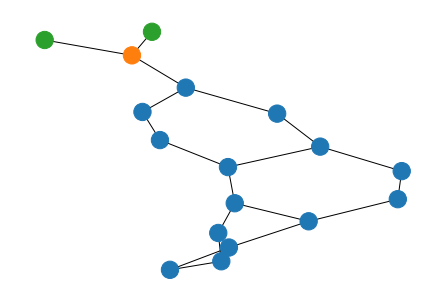

In [ ]:
draw_graph(mutag_0)

### Part 2.2: Transformations

Transformations are a quick way to include standard preprocessing when loading the graphs (e.g., automatically computing edge from the nodes positions). See the full list of available transformations here: 

https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html

In [ ]:
# As an experiment, we load the graph with a sparse adjacency format instead of the COO list
mutag_adj = ptgeom.datasets.TUDataset(root='.', name='MUTAG', 
                                  transform=ptgeom.transforms.ToSparseTensor())

In [ ]:
# We now have the adjacency matrix available as an additional property
mutag_adj[0].adj_t

SparseTensor(row=tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
                            8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
                           15, 16]),
             col=tensor([ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
                            7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
                           14, 14]),
             size=(17, 17), nnz=38, density=13.15%)

In [ ]:
# The format has a number of useful methods that are already implemented: https://github.com/rusty1s/pytorch_sparse
# For example, we can perform a single step of diffusion on the node features efficiently with a sparse-dense matrix multiplication
print(torch_sparse.matmul(mutag_adj[0].adj_t, mutag_adj[0].x).shape)

torch.Size([17, 7])


In [ ]:
# Or, print the size of the matrix
print(mutag_adj[0].adj_t.sizes())

[17, 17]


### Part 3.1: Data loaders

Data loaders are a nice utility to automatically build mini-batches (either a subset of graphs, or a subgraph extracted from a single graph) from the dataset.

In [ ]:
# First, we split the original dataset into a training and test spart with a stratified split on the class
train_idx, test_idx = train_test_split(range(len(mutag)), stratify=[m.y[0].item() for m in mutag], test_size=0.25)

In [ ]:
# Build the two loaders
train_loader = ptgeom.loader.DataLoader(mutag[train_idx], batch_size=32, shuffle=True)
test_loader = ptgeom.loader.DataLoader(mutag[test_idx], batch_size=32)

In [ ]:
# Let us inspect the first batch of data
batch = next(iter(train_loader))

In [ ]:
# The batch is built by considering all the subgraphs as a single giant graph with unconnected components
print(batch.x.shape) # All the nodes of the 32 graphs are put together
print(batch.y.shape) # A single label for each graph
print(batch.edge_index.shape)

torch.Size([561, 7])
torch.Size([32])
torch.Size([2, 1246])


In [ ]:
# There is an additional property linking each node to its corresponding graph index
print(batch.batch.shape)
print(batch.batch[0:30])

torch.Size([561])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


In [ ]:
# We can perform a graph-level average with torch_scatter, see the figure here for a visual explanation:
# https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html
torch_scatter.scatter_sum(batch.x, batch.batch, dim=0).shape

torch.Size([32, 7])

In [ ]:
# Alternatively, PyG has this implemented as a functional layer
ptgeom.nn.global_mean_pool(batch.x, batch.batch).shape

torch.Size([32, 7])

### Part 3.2: Building the graph neural network

In [ ]:
# Layers in PyG are very similar to PyTorch, e.g., this is a standard graph convolutional layer
gc = ptgeom.nn.GCNConv(7, 12)

In [ ]:
gc(batch.x, batch.edge_index).shape

torch.Size([561, 12])

In [ ]:
# Different layers have different properties, see this "cheatsheet" from the documentation:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html
# For example, GCNConv accepts an additional "edge_weight" parameter to weight each edge. We will use this later on,
# to mask the corresponding edges for the prediction.

In [ ]:
# If you are not used to PyTorch Lightning, see the 5-minutes intro from here:
# https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html
class MUTAGClassifier(ptlight.LightningModule):
    
    def __init__(self):
      # The model is just GCNConv --> GCNConv --> graph pooling --> Dropout --> Linear
      super().__init__()
      self.gc1 = ptgeom.nn.GCNConv(7, 256)
      self.gc2 = ptgeom.nn.GCNConv(256, 256)
      self.linear = torch.nn.Linear(256, 1)

    def forward(self, x, edge_index=None, batch=None, edge_weight=None):
      # Note: "edge_weight" is not used for training, but only for the explainability part
      if edge_index == None:
        x, edge_index, batch = x.x, x.edge_index, x.batch
      x = F.relu(self.gc1(x, edge_index, edge_weight))
      x = F.relu(self.gc2(x, edge_index, edge_weight))
      x = ptgeom.nn.global_mean_pool(x, batch)
      x = F.dropout(x)
      x = self.linear(x)
      return x
 
    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      return optimizer

    def training_step(self, batch, _):
      y_hat = self.forward(batch.x, batch.edge_index, batch.batch)
      loss = F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float())
      self.log("train_loss", loss)
      self.log("train_accuracy", accuracy(y_hat, batch.y.unsqueeze(1)), prog_bar=True, batch_size=32)
      return loss

    def validation_step(self, batch, _):
        x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch
        y_hat = self.forward(x, edge_index, batch_idx)
        self.log("val_accuracy", accuracy(y_hat, batch.y.unsqueeze(1)), prog_bar=True, batch_size=32)

In [ ]:
# We instantiate the classifier
gnn = MUTAGClassifier()

In [ ]:
# Sanity check: we run a single mini-batch and check the output shape
gnn(batch.x, batch.edge_index, batch.batch).shape

torch.Size([32, 1])

### Part 3.3: Training the network

In [ ]:
# We save checkpoints every 50 epochs (note: not used for now, planning to add TracIn later)
checkpoint_callback = ptlight.callbacks.ModelCheckpoint(
    dirpath='./checkpoints/',
    filename='gnn-{epoch:02d}',
    every_n_epochs=50,
    save_top_k=-1)

In [ ]:
trainer = ptlight.Trainer(max_epochs=200, callbacks=[checkpoint_callback])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# This is not a particularly well-designed model, we expect approximately 80% test accuracy
trainer.fit(gnn, train_loader, test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name   | Type    | Params
-----------------------------------
0 | gc1    | GCNConv | 2.0 K 
1 | gc2    | GCNConv | 65.8 K
2 | linear | Linear  | 257   
-----------------------------------
68.1 K    Trainable params
0         Non-trainable params
68.1 K    Total params
0.272     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Part 4.1: Explainability with GNNExplainer

GNNExplainer is a simple method to search for instance-level explanations on a trained GNN. It optimizes for the smallest feature and edge masks that do not vary the prediction of the trained model. See the full explanation in the original paper: https://arxiv.org/pdf/1903.03894.pdf

In [ ]:
# We take a single graph from the test dataset
idx = 0
test_graph = mutag[test_idx[idx]]

In [ ]:
# Explanations are mostly interesting for mutagenic graphs
print(test_graph.y)

tensor([1])


In [ ]:
# PyG has an implementation of GNNExplainer that we will use
# feat_mask_type provides a mask that can remove individual features for each node
explainer = ptgeom.nn.GNNExplainer(gnn, feat_mask_type="individual_feature", epochs=500)

In [ ]:
# Run a gradient descent loop to optimize the masks
result = explainer.explain_graph(test_graph.x, test_graph.edge_index)


Explain graph: 100%|██████████| 500/500 [00:02<00:00, 220.14it/s]


In [ ]:
# These are the resulting masks, we mostly care about the edges here
(feature_mask, edge_mask) = result
print(edge_mask.shape)
print(feature_mask.shape)

torch.Size([54])
torch.Size([23, 7])


In [ ]:
# Get the highest values inside the edge mask (relevant edges)
edges_idx = edge_mask > 0.8

In [ ]:
# We build the subgraph corresponding to the explanation
explanation = ptgeom.data.Data(test_graph.x, test_graph.edge_index[:, edges_idx])

In [ ]:
# Make undirected and remove the isolated nodes 
explanation = ptgeom.transforms.RemoveIsolatedNodes()(ptgeom.transforms.ToUndirected()(explanation))

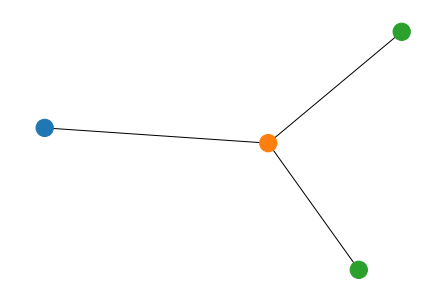

In [ ]:
# A good explanation should contain carbon rings, NH2, and NO2 groups, which are known to be mutagenic
draw_graph(explanation)

### Part 4.2: Integrated gradients

Instead of using a custom-made explainer, we can also try using a "standard" one. For example, here we use the implementation of integrated gradients provided by Captum. This will integrate a "saliency vector" moving from a graph with no connectivity to our actual graph.

In [ ]:
# We just define a custom function whose input is the edge mask
batch_idx = torch.zeros(test_graph.x.shape[0], dtype=torch.int64) # All nodes belong to the same graph
gnn.eval()
def model_forward(edge_mask):
    out = gnn(test_graph.x, test_graph.edge_index, batch_idx, edge_weight=edge_mask[0])
    return out

In [ ]:
# Initialize the edge mask
edge_mask = torch.ones(test_graph.edge_index.shape[1]).unsqueeze(0).requires_grad_(True)

In [ ]:
# See the API from here:
# https://captum.ai/docs/extension/integrated_gradients
ig = IntegratedGradients(model_forward)

In [ ]:
mask = ig.attribute(edge_mask, internal_batch_size=1)

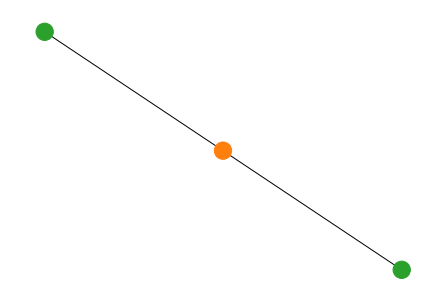

In [ ]:
# This is identical to before, using the new mask
explanation = ptgeom.data.Data(test_graph.x, test_graph.edge_index[:, mask[0] > 0.1])
explanation = ptgeom.transforms.RemoveIsolatedNodes()(ptgeom.transforms.ToUndirected()(explanation))
draw_graph(explanation)